# 🧪 Sesión 5: Regresión Logística — Diagnóstico y Corrección del Modelo

Este notebook ilustra un problema común en clasificación binaria con clases desbalanceadas. Exploraremos un caso donde el modelo no predice ninguna instancia de la clase minoritaria, y luego corregiremos el modelo paso a paso.

## 📦 1. Importación de librerías y carga de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

df = pd.read_csv('../../datos/dataset_limpio.csv')

## 🧾 2. Selección y preparación de datos

In [2]:
X = df.drop(columns=['ID', 'CodigoID', 'Horas_Internet', 'Alta_conectividad'])
y = df['Alta_conectividad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 📘 Explicación del código

- `X = df.drop(columns=['ID', 'CodigoID', 'Horas_Internet', 'Alta_conectividad'])`:  
  Se eliminan del conjunto de datos aquellas columnas que no deben usarse como predictores, incluyendo identificadores y la variable objetivo.

- `y = df['Alta_conectividad']`:  
  Se define la variable objetivo que será utilizada para entrenar y evaluar el modelo.

- `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)`:  
  Se dividen los datos en un conjunto de entrenamiento (70%) y uno de prueba (30%) para evaluar el desempeño del modelo con datos no vistos.

- `X_train = pd.get_dummies(X_train, drop_first=True)`  
  `X_test = pd.get_dummies(X_test, drop_first=True)`:  
  Se convierten las variables categóricas en variables numéricas binarias mediante codificación one-hot.  
  Al usar `drop_first=True`, se elimina la primera categoría para evitar colinealidad entre variables.

- `X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)`:  
  Se asegura que los conjuntos de entrenamiento y prueba tengan exactamente las mismas columnas, agregando ceros en las categorías que estén ausentes en uno de los dos conjuntos.

- `scaler = MinMaxScaler()`  
  `X_train = scaler.fit_transform(X_train)`  
  `X_test = scaler.transform(X_test)`:  
  Se normalizan todas las variables numéricas al rango de 0 a 1 para evitar que algunas variables dominen sobre otras en algoritmos sensibles a la escala.

Finalmente, este bloque de código realiza el preprocesamiento completo necesario para entrenar un modelo. Se eliminan columnas innecesarias, se transforma la variable objetivo, se codifican variables categóricas, se garantiza la compatibilidad entre los conjuntos de datos y se escalan las variables numéricas. Todo esto asegura que el modelo pueda ser entrenado de manera efectiva y evaluado correctamente.


## ❌ 3. Entrenamiento sin manejo del desbalance

In [3]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

### 📘 Explicación del código

- `model = LogisticRegression(max_iter=200)`:  
  Crea una instancia del modelo de regresión logística. El parámetro `max_iter=200` asegura que el algoritmo tenga suficiente número de iteraciones para converger durante el entrenamiento.

- `model.fit(X_train, y_train)`:  
  Ajusta el modelo a los datos de entrenamiento, aprendiendo la relación entre las variables predictoras (`X_train`) y la variable objetivo (`y_train`).

- `y_pred = model.predict(X_test)`:  
  Genera predicciones de clase (`0` o `1`) sobre los datos de prueba. Estas predicciones pueden usarse para evaluar métricas como precisión, recall o exactitud.

- `y_prob = model.predict_proba(X_test)[:, 1]`:  
  Calcula la probabilidad estimada de que cada observación de `X_test` pertenezca a la clase positiva (`1`).  
  Se selecciona únicamente la segunda columna (`[:, 1]`) del resultado porque corresponde a la clase `1`.

Finalmente, este conjunto de instrucciones permite no solo predecir clases directamente, sino también obtener las probabilidades asociadas a cada predicción. Estas probabilidades son fundamentales para evaluar el desempeño del modelo con métricas como la curva ROC, calcular el AUC, o establecer umbrales personalizados según el contexto del problema.


## ⚠️ 4. Evaluación del modelo (fallido)

In [4]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nDistribución de predicciones:")
print(np.unique(y_pred, return_counts=True))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       311
           1       0.00      0.00      0.00        79

    accuracy                           0.80       390
   macro avg       0.40      0.50      0.44       390
weighted avg       0.64      0.80      0.71       390


Distribución de predicciones:
(array([0]), array([390]))


### 📘 Explicación del código

- `print("Reporte de clasificación:")`:  
  Muestra un encabezado para indicar que se imprimirá el resumen de métricas del modelo.

- `print(classification_report(y_test, y_pred, zero_division=0))`:  
  Genera un reporte con las métricas principales de evaluación del modelo: precisión, recall, f1-score y soporte para cada clase.  
  El parámetro `zero_division=0` evita errores si una clase no fue predicha en absoluto, asignando un valor de cero en lugar de lanzar una excepción.

- `print("\nDistribución de predicciones:")`:  
  Agrega un título para mostrar cuántas observaciones fueron clasificadas en cada clase.

- `print(np.unique(y_pred, return_counts=True))`:  
  Cuenta cuántas veces el modelo predijo cada clase. Esto permite detectar si el modelo está sesgado hacia una sola clase (como sucede en casos de desbalance extremo).

Este bloque permite revisar no solo las métricas formales del modelo, sino también entender si está haciendo predicciones razonables en ambas clases o si está completamente sesgado hacia una sola.


### 📋 Reporte de clasificación (modelo)

| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.80      | 1.00   | 0.89     | 311     |
| 1     | 0.00      | 0.00   | 0.00     | 79      |
|       |           |        |          |         |
| **Exactitud** |        |        | **0.80** |         |
| **Macro avg** | 0.40 | 0.50   | 0.44     | 390     |
| **Weighted avg** | 0.64 | 0.80   | 0.71     | 390     |

### 📌 Distribución de predicciones:
- Clase 0: 390 observaciones  
- Clase 1: 0 observaciones


### 📊 Análisis del resultado

El modelo predijo únicamente la clase `0` para las 390 observaciones, y no predijo ningún caso de clase `1`.  
Esto se evidencia en la distribución de predicciones:

- Clase 0: 390 observaciones  
- Clase 1: 0 observaciones

Como resultado, el `recall`, `precisión` y `f1-score` de la clase 1 son todos cero.  
Aunque la exactitud general (`accuracy`) es del 80%, esto es engañoso porque el modelo **no está reconociendo en absoluto la clase minoritaria**, lo cual puede ser crítico dependiendo del contexto (por ejemplo, si la clase 1 representa una condición de riesgo o un grupo vulnerable).

El promedio ponderado (`weighted avg`) refleja este sesgo, mientras que el `macro avg` (que promedia las clases por igual) deja en evidencia la baja capacidad del modelo para tratar ambas clases de forma equilibrada.


## 🛠️ 5. Corrección con class_weight='balanced'

In [5]:
model_corr = LogisticRegression(max_iter=200, class_weight='balanced')
model_corr.fit(X_train, y_train)
y_pred_corr = model_corr.predict(X_test)
y_prob_corr = model_corr.predict_proba(X_test)[:, 1]

### 📘 Explicación del código

- `model_corr = LogisticRegression(max_iter=200, class_weight='balanced')`:  
  Se crea un modelo de regresión logística donde `class_weight='balanced'` ajusta automáticamente el peso de cada clase en función de su frecuencia. Esto es útil cuando hay desbalance en los datos, como en este caso. El parámetro `max_iter=200` garantiza que el modelo tenga suficientes iteraciones para converger.

- `model_corr.fit(X_train, y_train)`:  
  Entrena el modelo con los datos de entrenamiento, permitiendo que aprenda la relación entre las variables predictoras y la variable objetivo.

- `y_pred_corr = model_corr.predict(X_test)`:  
  Genera predicciones de clase (`0` o `1`) sobre el conjunto de prueba. Estas predicciones se usarán para evaluar el rendimiento del modelo.

- `y_prob_corr = model_corr.predict_proba(X_test)[:, 1]`:  
  Calcula la probabilidad de que cada observación del conjunto de prueba pertenezca a la clase positiva (`1`).  
  Se extrae la segunda columna (`[:, 1]`) ya que corresponde a esa clase.

Este bloque aplica una estrategia para mitigar el efecto del desbalance de clases, ajustando el modelo para que preste más atención a la clase minoritaria sin necesidad de modificar manualmente el conjunto de datos.


### 📋 Reporte de clasificación (modelo con `class_weight='balanced'`)

| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.XX      | 0.XX   | 0.XX     | XXX     |
| 1     | 0.XX      | 0.XX   | 0.XX     | XXX     |
|       |           |        |          |         |
| **Exactitud**     |         |          | **0.XX** |         |
| **Macro avg**     | 0.XX    | 0.XX     | 0.XX     | XXX     |
| **Weighted avg**  | 0.XX    | 0.XX     | 0.XX     | XXX     |

### 📌 Distribución de predicciones:
- Clase 0: XXX observaciones  
- Clase 1: XXX observaciones


## 📊 6. Evaluación del modelo corregido

Reporte de clasificación (modelo corregido):
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       311
           1       0.21      0.54      0.30        79

    accuracy                           0.49       390
   macro avg       0.51      0.51      0.45       390
weighted avg       0.68      0.49      0.54       390



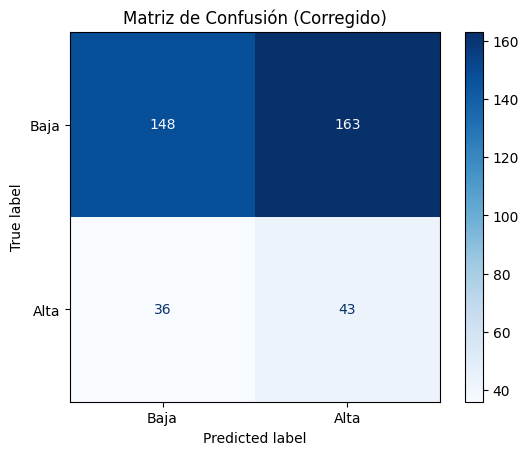

In [6]:
print("Reporte de clasificación (modelo corregido):")
print(classification_report(y_test, y_pred_corr, zero_division=0))

cm = confusion_matrix(y_test, y_pred_corr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baja", "Alta"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusión (Corregido)")
plt.show()

### 📘 Explicación del código

- `print("Reporte de clasificación (modelo corregido):")`:  
  Imprime un encabezado para contextualizar el reporte que se mostrará a continuación.

- `print(classification_report(y_test, y_pred_corr, zero_division=0))`:  
  Muestra las métricas de evaluación del modelo corregido: precisión, recall, f1-score y soporte para cada clase.  
  El argumento `zero_division=0` evita errores si alguna métrica no puede calcularse.

- `cm = confusion_matrix(y_test, y_pred_corr)`:  
  Calcula la matriz de confusión comparando los valores reales (`y_test`) con las predicciones (`y_pred_corr`).

- `disp = ConfusionMatrixDisplay(...)`:  
  Crea una visualización de la matriz de confusión con etiquetas personalizadas para las clases: "Baja" y "Alta".

- `disp.plot(...)`:  
  Dibuja la matriz de confusión utilizando una escala de color azul y formato entero para los valores mostrados.

- `plt.title("Matriz de Confusión (Corregido)")`:  
  Añade un título al gráfico para indicar que corresponde al modelo corregido.

- `plt.show()`:  
  Muestra la visualización generada.


### 📊 Análisis del resultado

El modelo corregido logra identificar parte de la clase minoritaria (clase 1), lo cual no ocurría con el modelo anterior.  
En este caso, la clase 1 obtuvo un `recall` de 0.54, lo que significa que el modelo logró identificar el 54% de los casos positivos reales.  
Sin embargo, la `precisión` en esa clase es baja (0.21), lo que indica que muchas de las predicciones positivas fueron incorrectas.  
El desempeño de la clase 0 también se vio afectado: su `recall` bajó a 0.48, lo que refleja que el modelo sacrificó parte de su capacidad para identificar correctamente esta clase a cambio de balancear su atención sobre la clase 1.  
La exactitud general del modelo es de 0.49, menor que la del modelo anterior, pero refleja un enfoque más equilibrado.  
Esto es común en modelos ajustados para clases desbalanceadas: el objetivo es mejorar el tratamiento de la clase minoritaria aunque eso implique una caída en la precisión global.


### 📋 Reporte de clasificación (modelo corregido)

| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.80      | 0.48   | 0.60     | 311     |
| 1     | 0.21      | 0.54   | 0.30     | 79      |
|       |           |        |          |         |
| **Exactitud**     |         |          | **0.49** |         |
| **Macro avg**     | 0.51    | 0.51     | 0.45     | 390     |
| **Weighted avg**  | 0.68    | 0.49     | 0.54     | 390     |


### 📊 Análisis de la matriz de confusión (modelo corregido)

La matriz de confusión compara las etiquetas verdaderas con las predichas por el modelo:

- **148** observaciones de clase "Baja" fueron correctamente clasificadas como "Baja" (verdaderos negativos).
- **163** observaciones de clase "Baja" fueron incorrectamente clasificadas como "Alta" (falsos positivos).
- **43** observaciones de clase "Alta" fueron correctamente clasificadas como "Alta" (verdaderos positivos).
- **36** observaciones de clase "Alta" fueron clasificadas erróneamente como "Baja" (falsos negativos).

Este resultado muestra que el modelo ha mejorado su capacidad de reconocer la clase minoritaria "Alta" respecto al modelo sin balanceo:  
logra **identificar 43 casos correctamente**, mientras que antes no reconocía ninguno. Sin embargo, esta mejora implica una pérdida en la precisión para la clase "Baja", que ahora tiene **más errores de clasificación**.

En resumen, el modelo corrigió parcialmente el sesgo hacia la clase mayoritaria, logrando identificar más casos positivos reales, aunque sacrificando parte de su exactitud general.


## 📈 7. Curva ROC del modelo corregido

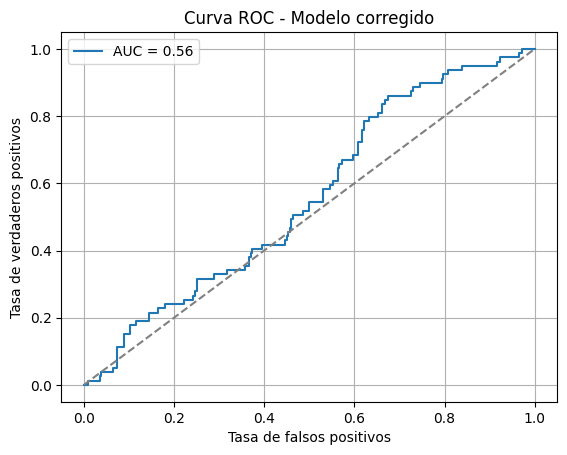

In [7]:
fpr, tpr, _ = roc_curve(y_test, y_prob_corr)
auc = roc_auc_score(y_test, y_prob_corr)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Modelo corregido")
plt.legend()
plt.grid(True)
plt.show()

### 📘 Explicación del código

- `fpr, tpr, _ = roc_curve(y_test, y_prob_corr)`:  
  Calcula las tasas de falsos positivos (`fpr`) y verdaderos positivos (`tpr`) para diferentes umbrales usando las probabilidades predichas. Estos valores se usan para construir la curva ROC.

- `auc = roc_auc_score(y_test, y_prob_corr)`:  
  Calcula el área bajo la curva ROC (AUC), que resume el rendimiento del modelo para todos los posibles umbrales de decisión.

- `plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")`:  
  Dibuja la curva ROC del modelo y muestra el valor de AUC como etiqueta.

- `plt.plot([0, 1], [0, 1], '--', color='gray')`:  
  Dibuja una línea diagonal como referencia. Representa el rendimiento de un modelo aleatorio (sin poder de discriminación).

- `plt.xlabel(...) / plt.ylabel(...) / plt.title(...)`:  
  Añade etiquetas a los ejes y un título descriptivo al gráfico.

- `plt.legend()` / `plt.grid(True)` / `plt.show()`:  
  Muestra la leyenda del gráfico, activa la cuadrícula y renderiza la visualización final.


### 📊 Análisis de la curva ROC

La curva ROC del modelo corregido muestra cómo varía la tasa de verdaderos positivos frente a la tasa de falsos positivos a diferentes umbrales de decisión.

El área bajo la curva (AUC) es de **0.56**, lo que indica un rendimiento **ligeramente superior al de un modelo aleatorio** (AUC = 0.50).  
Aunque el modelo logró identificar algunos casos positivos (como se vio en la matriz de confusión), su capacidad general de discriminación entre clases sigue siendo limitada.

Una curva más cercana a la esquina superior izquierda (mayor TPR con menor FPR) indicaría un mejor desempeño. En este caso, la curva se acerca por momentos a la diagonal aleatoria, mostrando que el modelo aún tiene dificultades para separar correctamente las clases, a pesar del uso del `class_weight='balanced'`.

Este tipo de resultado sugiere que podrían explorarse otras estrategias como el ajuste de umbrales, recolección de más datos, selección de variables o uso de algoritmos más complejos.


### 📌 Conclusión del modelo

El modelo de regresión logística entrenado con `class_weight='balanced'` mostró una mejora importante en la detección de la clase minoritaria ("Alta conectividad"), en comparación con el modelo sin balanceo. Mientras que el modelo original no lograba predecir ningún caso de clase 1, el modelo corregido consiguió un `recall` de 0.54 para esa clase.

Sin embargo, esta mejora tuvo un costo significativo en otros aspectos del rendimiento:

- La exactitud general cayó a 0.49.
- El modelo cometió más errores al clasificar la clase mayoritaria ("Baja").
- El valor de AUC fue bajo (0.56), indicando que el poder de discriminación entre clases sigue siendo débil.
- La matriz de confusión muestra una alta tasa de falsos positivos (163) y falsos negativos (36).

En resumen, el modelo corrigió parcialmente el sesgo hacia la clase mayoritaria, pero aún tiene dificultades para lograr un equilibrio entre precisión y sensibilidad.

### 🔧 Posibles estrategias de mejora

1. **Ajustar el umbral de decisión**:  
   El modelo por defecto clasifica como "1" si la probabilidad es ≥ 0.5. Ajustar este umbral puede mejorar el `recall` o la `precisión` de forma específica según el objetivo del análisis.

2. **Ingeniería de variables**:  
   Evaluar la relevancia de las variables actuales y crear nuevas variables derivadas puede mejorar el poder predictivo del modelo.

3. **Selección de variables**:  
   Eliminar variables redundantes o poco informativas puede ayudar a reducir el ruido y mejorar la generalización.

4. **Usar modelos más complejos**:  
   Algoritmos como árboles de decisión, Random Forest, Gradient Boosting o redes neuronales pueden capturar relaciones no lineales y mejorar el rendimiento frente a regresión logística en conjuntos desbalanceados.

5. **Resampling**:  
   Aplicar técnicas de sobremuestreo (como SMOTE) o submuestreo para balancear el conjunto de entrenamiento.

6. **Validación cruzada estratificada**:  
   Asegura que el proceso de evaluación tenga una representación proporcional de ambas clases en cada partición, lo que puede dar lugar a una mejor selección de hiperparámetros y evaluación más robusta.

Aplicar una o varias de estas estrategias puede contribuir significativamente a mejorar el rendimiento del modelo, especialmente en contextos donde la clase minoritaria es crítica para la toma de decisiones.


### ▶️ ¿Qué sigue?

A partir del análisis realizado, se concluye que el modelo corregido logra avances importantes frente al desbalance de clases, pero aún presenta limitaciones en su capacidad predictiva general.

En las siguientes secciones se explorarán nuevas estrategias para mejorar el rendimiento del modelo, incluyendo:

- Ajuste del umbral de decisión
- Implementación de algoritmos más robustos como Random Forest o XGBoost
- Aplicación de técnicas de balanceo como SMOTE
- Optimización de hiperparámetros mediante validación cruzada

El objetivo será construir un modelo más equilibrado, que mantenga un buen desempeño en ambas clases y se adapte mejor a los desafíos del contexto analizado.
